# Test Keymorph

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
from argparse import ArgumentParser
import torchio as tio
from pathlib import Path

from keymorph.utils import rescale_intensity, align_img
from keymorph.model import KeyMorph
from keymorph.unet3d.model import UNet2D, UNet3D, TruncatedUNet3D
from keymorph.net import ConvNet
# from pairwise_register_eval import run_eval
# from groupwise_register_eval import run_group_eval
from scripts.script_utils import summary, load_checkpoint

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torchio'

In [ ]:
def get_model(args):
    if args.registration_model == "keymorph":
        # CNN, i.e. keypoint extractor
        if args.backbone == "conv":
            network = ConvNet(
                args.dim,
                1,
                args.num_keypoints,
                norm_type=args.norm_type,
            )
        elif args.backbone == "unet":
            if args.dim == 2:
                network = UNet2D(
                    1,
                    args.num_keypoints,
                    final_sigmoid=False,
                    f_maps=64,
                    layer_order="gcr",
                    num_groups=8,
                    num_levels=args.num_levels_for_unet,
                    is_segmentation=False,
                    conv_padding=1,
                )
            if args.dim == 3:
                network = UNet3D(
                    1,
                    args.num_keypoints,
                    final_sigmoid=False,
                    f_maps=32,  # Used by nnUNet
                    layer_order="gcr",
                    num_groups=8,
                    num_levels=args.num_levels_for_unet,
                    is_segmentation=False,
                    conv_padding=1,
                    use_checkpoint=args.use_checkpoint,
                )
        elif args.backbone == "truncatedunet":
            if args.dim == 3:
                network = TruncatedUNet3D(
                    1,
                    args.num_keypoints,
                    args.num_truncated_layers_for_truncatedunet,
                    final_sigmoid=False,
                    f_maps=32,  # Used by nnUNet
                    layer_order="gcr",
                    num_groups=8,
                    num_levels=args.num_levels_for_unet,
                    is_segmentation=False,
                    conv_padding=1,
                )
        else:
            raise ValueError('Invalid keypoint extractor "{}"'.format(args.backbone))
        network = torch.nn.DataParallel(network)

        # Keypoint model
        registration_model = KeyMorph(
            network,
            args.num_keypoints,
            args.dim,
            use_amp=args.use_amp,
            use_checkpoint=args.use_checkpoint,
            weight_keypoints=args.weighted_kp_align,
            align_keypoints_in_real_world_coords=args.align_keypoints_in_real_world_coords, 
        )
        registration_model.to(args.device)
        summary(registration_model)
    elif args.registration_model == "itkelastix":
        from keymorph.baselines.itkelastix import ITKElastix

        registration_model = ITKElastix()
    elif args.registration_model == "synthmorph":

        from keymorph.baselines.voxelmorph import VoxelMorph

        registration_model = VoxelMorph(perform_preaffine_register=True)
    elif args.registration_model == "synthmorph-no-preaffine":

        from keymorph.baselines.voxelmorph import VoxelMorph

        registration_model = VoxelMorph(perform_preaffine_register=False)
    elif args.registration_model == "ants":
        from keymorph.baselines.ants import ANTs

        registration_model = ANTs()
    else:
        raise ValueError(
            'Invalid registration model "{}"'.format(args.registration_model)
        )
    return registration_model

def get_foundation_weights_path(weights_dir, num_keypoints, num_levels):
    template_name = "foundation-numkey{}-numlevels{}.pth.tar"
    return os.path.join(weights_dir, template_name.format(num_keypoints, num_levels))

def show_3d_mid(load_train_img_np, cmap="gray", title = ''):
    def show_slices(slices, cmap):
       """ Function to display row of image slices """
       fig, axes = plt.subplots(1, len(slices))
       for i, slice in enumerate(slices):
           axes[i].imshow(slice, cmap=cmap) #, origin="lower"
           if isinstance(cmap, str) == False:
               from matplotlib.pyplot import pcolormesh
               axes[i].pcolormesh(slice, cmap=cmap, rasterized=True, vmin=0, vmax=255)
           if i==1:
               axes[i].set_title(title)

    H,W,C = load_train_img_np.shape
    print(f"Shape of input is {H,W,C}")
    slice_0 = load_train_img_np[int(H/2), :, :]
    slice_1 = load_train_img_np[:,int(W/2), :]
    slice_2 = load_train_img_np[:, :, int(C/2)]
    show_slices([slice_0, slice_1, slice_2], cmap)
    plt.tight_layout()
    plt.show()
    
def load_img(img_path, norm = True, show = False, toRAS = True):
    ''' Load image and normalize as is done in get_loader.
    Our images are already volumes of 256**3 isotropic 1-mm voxels, so
    resampling, cropping, and padding are unnecessary.'''
    f = tio.ScalarImage(img_path)
    print(f'Loaded image {f}')
    if show:
        show_3d_mid(f.data.float().squeeze(), cmap='gray', title= 'Load image before ToCanonical')
    if norm:
        f = tio.Lambda(rescale_intensity)(f)
        
    # Transpose and flip image such that its axes are roughly aligned with RAS.
    ori_to_world = f.affine
    print(f'ori_to_world:{ori_to_world}')
    if toRAS:
        f = tio.ToCanonical()(f)
    ras_to_world = f.affine
    ori_to_ras = np.linalg.inv(ras_to_world) @ ori_to_world
    print(f'ras_to_world:{ras_to_world}')
    print(f'ori_to_ras:{ori_to_ras}')
    print(f'Loaded image after preprocessing {f}')
    
    return ori_to_ras, ras_to_world, f.data.unsqueeze(0).float()

In [3]:
# Hardcode some args
parser = ArgumentParser()
args, unknown = parser.parse_known_args()
args.gpus = '0'
args.seed = 23
args.use_amp = False
args.use_checkpoint = False
args.half_resolution = False

# - Model
args.registration_model = "keymorph"
args.backbone = "truncatedunet"
args.dim = 3
args.num_keypoints = 256
args.num_levels_for_unet = 6
args.weights_dir = "./weights/"
args.list_of_aligns = ["rigid", "affine"]
args.num_truncated_layers_for_truncatedunet = 1
args.weighted_kp_align = "power"
args.align_keypoints_in_real_world_coords = False # Don't make things more complicated; disenable it!

# - Data
args.moving="/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m00.nii.gz"
args.fixed ="/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz"

# - Output
args.save_dir = "./register_output/"
args.moved = "./register_output/aff.ima.1.nii.gz"
args.trans = "./register_output/aff.tra.1.txt"

# Select GPU
if torch.cuda.is_available():
    args.device = torch.device("cuda:" + str(args.gpus))
else:
    args.device = torch.device("cpu")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpus
print("Number of GPUs: {}".format(torch.cuda.device_count()))
print(f"Torch version is {torch.__version__}")

# Create save path
save_path = Path(args.save_dir)
if not os.path.exists(save_path) and args.save_eval_to_disk:
    os.makedirs(save_path)
args.model_eval_dir = save_path

# Set seed
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# Model
registration_model = get_model(args)
registration_model.eval()

# Checkpoint loading
if args.half_resolution and args.registration_model == "keymorph":
    assert (
        args.load_path is not None
    ), "Must specify path for weights for half resolution models"
else:
    args.load_path = get_foundation_weights_path(
        args.weights_dir, args.num_keypoints, args.num_levels_for_unet
    )
if args.load_path is not None:
    print(f"Loading checkpoint from {args.load_path}")
    ckpt_state, registration_model = load_checkpoint(
        args.load_path,
        registration_model,
        device=args.device,
    )

Number of GPUs: 1
Torch version is 1.11.0

Model Summary
---------------------------------------------------------------
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv1.conv.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv2.conv.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv1.conv.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv2.conv.weight
backbone.module.encoders.2.basic_module.SingleConv1.groupnorm.weight
backbone.m

Loaded image ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; path: "/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz")
Shape of input is (256, 256, 256)


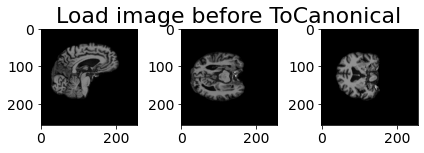

ori_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ras_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ori_to_ras:[[ 1.00000000e+00 -2.18952885e-47  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.93433942e-52 -1.22657011e-43  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Loaded image after preprocessing ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.FloatTensor; memory: 64

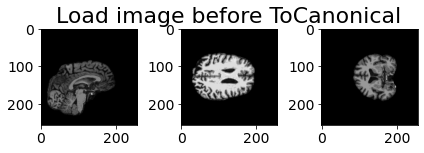

ori_to_world:[[-1.00000000e+00 -1.98523347e-23  0.00000000e+00  1.27254433e+02]
 [ 8.88178420e-16 -8.88178420e-16  1.00000000e+00 -1.08314606e+02]
 [-1.32348898e-23 -1.00000000e+00 -1.37574877e-24  1.45902100e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ras_to_world:[[-1.00000000e+00 -1.98523347e-23  0.00000000e+00  1.27254433e+02]
 [ 8.88178420e-16 -8.88178420e-16  1.00000000e+00 -1.08314606e+02]
 [-1.32348898e-23 -1.00000000e+00 -1.37574877e-24  1.45902100e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ori_to_ras:[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.17549435e-38 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Loaded image after preprocessing ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.FloatTensor; memory: 64.0 MiB)
Shape of

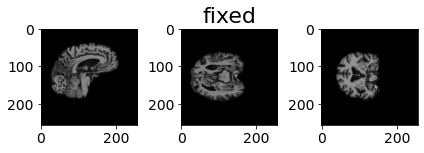

Shape of input is (256, 256, 256)


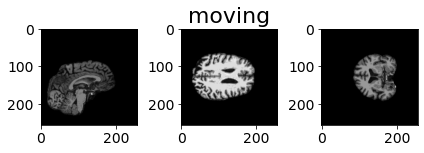

In [4]:
# Data, disenable to RAS for now
toRAS = False
fix_to_vox, aff_f, img_f = load_img(args.fixed, show = True, toRAS = toRAS)
mov_to_vox, aff_m, img_m = load_img(args.moving, show = True, toRAS = toRAS)
# Move to device
img_f = img_f.float().to(args.device)
img_m = img_m.float().to(args.device)
aff_f = torch.from_numpy(np.expand_dims(aff_f, axis=0)) # RAS-tp-World
aff_m = torch.from_numpy(np.expand_dims(aff_m, axis=0))

# Visualize
show_3d_mid(img_f.cpu().squeeze(), cmap='gray', title= 'fixed')
show_3d_mid(img_m.cpu().squeeze(), cmap='gray', title= 'moving')

In [5]:
# Register
with torch.set_grad_enabled(False):
    registration_results = registration_model(
        img_f,
        img_m,
        transform_type=args.list_of_aligns,
        return_aligned_points=True,
        align_keypoints_in_real_world_coords = args.align_keypoints_in_real_world_coords,
        # aff_f=aff_f.to(img_f),
        # aff_m=aff_m.to(img_m),
    )

In [7]:
registration_results["rigid"].keys()

dict_keys(['grid', 'points_f', 'points_m', 'points_weights', 'tps_lmbda', 'time_keypoint_extract', 'time_align', 'time', 'matrix', 'points_a'])

Loaded image ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; path: "/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz")
ori_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ras_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ori_to_ras:[[ 1.00000000e+00 -2.18952885e-47  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.93433942e-52 -1.22657011e-43  1.00000000e+00  0.00000000e+00]
 [ 0.00000000

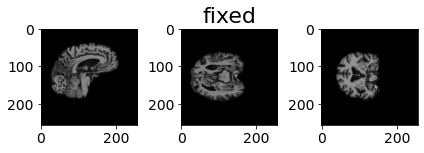

Shape of input is (256, 256, 256)


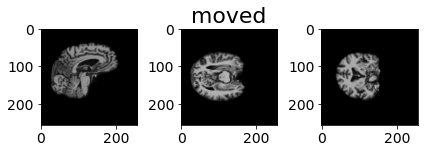

Shape of input is (256, 256, 256)


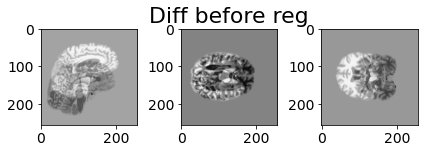

Shape of input is (256, 256, 256)


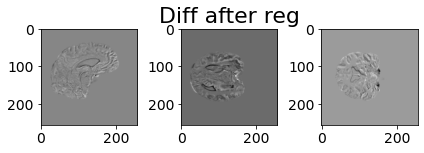

In [49]:
grid = registration_results["rigid"]["grid"].cpu().detach()
*_, img_f = load_img(args.fixed, norm=False, toRAS = toRAS)
*_, img_m = load_img(args.moving, norm=False, toRAS = toRAS)
img_a = align_img(grid, img_m)
show_3d_mid(img_f.cpu().squeeze(), cmap='gray', title= 'fixed')
show_3d_mid(img_a.cpu().squeeze(), cmap='gray', title= 'moved')
show_3d_mid(img_f.cpu().squeeze() - img_m.cpu().squeeze(), cmap='gray', title= 'Diff before reg')
show_3d_mid(img_f.cpu().squeeze() - img_a.cpu().squeeze(), cmap='gray', title= 'Diff after reg')

In [48]:
# Save moved
fix_to_ras, aff_f, img_f = load_img(args.fixed, norm=False, toRAS = toRAS)
mov_to_ras, aff_m, img_m = load_img(args.moving, norm=False, toRAS = toRAS)
save_name = './register_output/rig.tra.1.noRAS.nii.gz'
print(f'Saving moved image as {save_name}') 
out = tio.ScalarImage(tensor=img_a[0, ...].cpu(), affine=aff_f)
out.save(path=save_name, squeeze=True)

Loaded image ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; path: "/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz")
ori_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ras_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ori_to_ras:[[ 1.00000000e+00 -2.18952885e-47  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.93433942e-52 -1.22657011e-43  1.00000000e+00  0.00000000e+00]
 [ 0.00000000

In [20]:
# Get transform from points
from keymorph.utils import convert_points_norm2voxel
points_f = registration_results["rigid"]["points_f"][0].cpu().detach().numpy()
points_m = registration_results["rigid"]["points_m"][0].cpu().detach().numpy()
print(np.min(points_f), np.max(points_f))
# Convert to voxel space
shape_img = (256, 256, 256)
shape_img = torch.tensor(shape_img).to(img_f)
points_f = convert_points_norm2voxel(registration_results["rigid"]["points_f"], shape_img)
points_m = convert_points_norm2voxel(registration_results["rigid"]["points_m"], shape_img)
points_f = points_f[0].cpu().detach().numpy()
points_m = points_m[0].cpu().detach().numpy()
print(np.min(points_f), np.max(points_f), points_f.shape)

-0.57543766 0.38847315
53.84398 177.22456 (256, 3)


In [39]:
from keymorph.keypoint_aligners import RigidKeypointAligner, AffineKeypointAligner
# Get key points in voxel space
points_f = convert_points_norm2voxel(registration_results["rigid"]["points_f"], shape_img)
points_m = convert_points_norm2voxel(registration_results["rigid"]["points_m"], shape_img)

# Fit rigid
keymorph_aligner = RigidKeypointAligner(
    points_m = points_m,
    points_f = points_f,
    w = registration_results["rigid"]["points_weights"],
    aff_f = None,
    aff_m = None,
    shape_f = img_f.shape,
    shape_m = img_m.shape,
    dim = args.dim,
    align_in_real_world_coords=args.align_keypoints_in_real_world_coords,
)

# Get inverse matrix
inverse_matrix = keymorph_aligner.inverse_transform_matrix[0].cpu().detach().numpy()
print(inverse_matrix)
save_name = './register_output/rig.tra.1.voxelspace.invert.txt'
np.savetxt(fname=save_name, X=inverse_matrix, fmt='%.8f %.8f %.8f %.8f')

# Get matrix
matrix = keymorph_aligner.transform_matrix[0].cpu().detach().numpy()
print(matrix)
save_name = './register_output/rig.tra.1.voxelspace.txt'
np.savetxt(fname=save_name, X=matrix, fmt='%.8f %.8f %.8f %.8f')

[[ 9.9902797e-01 -3.6473289e-02  2.5048673e-02  3.5947571e+00]
 [ 3.4562886e-02  9.9667335e-01  7.4093819e-02  3.3226082e+01]
 [-2.7786732e-02 -7.2808146e-02  9.9703348e-01  3.5662231e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 9.9900860e-01  3.4537796e-02 -2.7664945e-02 -4.6400895e+00]
 [-3.6515426e-02  9.9665797e-01 -7.3148519e-02 -3.2722908e+01]
 [ 2.5175247e-02  7.3743261e-02  9.9686265e-01 -6.0957332e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [40]:
from keymorph.keypoint_aligners import RigidKeypointAligner, AffineKeypointAligner
# Get key points in norm space
points_f = registration_results["rigid"]["points_f"]
points_m = registration_results["rigid"]["points_m"]
# Fit rigid
keymorph_aligner = RigidKeypointAligner(
    points_m = points_m,
    points_f = points_f,
    w = registration_results["rigid"]["points_weights"],
    aff_f = None,
    aff_m = None,
    shape_f = img_f.shape,
    shape_m = img_m.shape,
    dim = args.dim,
    align_in_real_world_coords=args.align_keypoints_in_real_world_coords,
)

# Get inverse matrix
inverse_matrix = keymorph_aligner.inverse_transform_matrix[0].cpu().detach().numpy()
print(inverse_matrix)
save_name = './register_output/rig.tra.1.normspace.invert.txt'
np.savetxt(fname=save_name, X=inverse_matrix, fmt='%.8f %.8f %.8f %.8f')

# Get inverse matrix
matrix = keymorph_aligner.transform_matrix[0].cpu().detach().numpy()
print(matrix)
save_name = './register_output/rig.tra.1.normspace.txt'
np.savetxt(fname=save_name, X=matrix, fmt='%.8f %.8f %.8f %.8f')

[[ 0.99902797 -0.03647329  0.02504867  0.01581072]
 [ 0.03456289  0.99667335  0.07409382  0.3645648 ]
 [-0.02778673 -0.07280815  0.9970335  -0.07503264]
 [ 0.          0.          0.          1.        ]]
[[ 0.9990086   0.0345378  -0.02766494 -0.03046208]
 [-0.03651543  0.99665797 -0.07314852 -0.3682576 ]
 [ 0.02517525  0.07374326  0.99686265  0.047515  ]
 [ 0.          0.          0.          1.        ]]


## Other tests

ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; path: "/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz")
ori_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ras_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; path: "/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz")
ScalarImage(shape: (1, 256, 256, 256); s

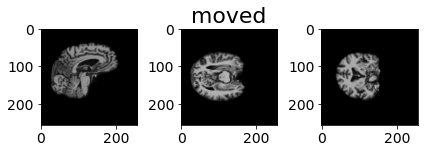

Shape of input is (256, 256, 256)


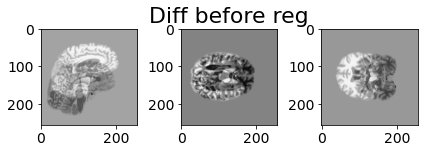

Shape of input is (256, 256, 256)


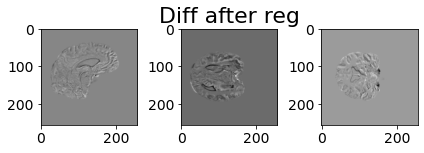

In [53]:
# align_keypoints_in_real_world_coords = False
grid = registration_results["rigid"]["grid"].cpu().detach()
*_, img_f = load_img(args.fixed, norm=False)
*_, img_m = load_img(args.moving, norm=False)
img_a = align_img(grid, img_m)
show_3d_mid(img_a.cpu().squeeze(), cmap='gray', title= 'moved')
show_3d_mid(img_f.cpu().squeeze() - img_m.cpu().squeeze(), cmap='gray', title= 'Diff before reg')
show_3d_mid(img_f.cpu().squeeze() - img_a.cpu().squeeze(), cmap='gray', title= 'Diff after reg')

In [56]:
# Save moved
fix_to_ras, aff_f, img_f = load_img(args.fixed, norm=False)
mov_to_ras, aff_m, img_m = load_img(args.moving, norm=False)
save_name = './register_output/aff.tra.1.realworldFalse.nii.gz'
print(f'Saving moved image as {save_name}') 
out = tio.ScalarImage(tensor=img_a[0, ...].cpu(), affine=aff_f)
out.save(path=save_name, squeeze=True)

ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; path: "/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz")
ori_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ras_to_world:[[-1.00000000e+00  1.03397577e-25  0.00000000e+00  1.30273041e+02]
 [ 1.11022302e-16  1.41895922e-27  9.99999881e-01 -5.98422089e+01]
 [-2.06795153e-25 -9.99999940e-01  0.00000000e+00  1.18560875e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
ScalarImage(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; path: "/autofs/space/bal_004/users/jf1212/code/affine_synthmorph/data/eval/adni-3t/0689/brainmask_m24.nii.gz")
ScalarImage(shape: (1, 256, 256, 256); s

In [55]:
matrix = registration_results["rigid"]["matrix"][0].cpu().detach().numpy()
print(matrix)
save_name = './register_output/aff.tra.1.realworldFalse.txt'
np.savetxt(fname=save_name, X=matrix, fmt='%.8f %.8f %.8f %.8f')

[[ 0.9990086   0.0345378  -0.02766494 -0.03046208]
 [-0.03651543  0.99665797 -0.07314852 -0.3682576 ]
 [ 0.02517525  0.07374326  0.99686265  0.047515  ]
 [ 0.          0.          0.          1.        ]]
